In [30]:
# import the required libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm

MZ = 91.188  # GeV
Gamma = 2.4414  # GeV
alpha = 1/132.507
GF = 1.16639e-5  # GeV^-2
GeV2_to_pb = 3.894e8  # 1 GeV^-2 = 3.894 × 10^8 pb
MZ = 91.188  # GeV
GammaZ = 2.4414  # GeV
alpha = 1/132.507
GF = 1.16639e-5  # GeV^-2
sin2thetaW= 0.222246
XMIN = 10 # GeV
XMAX = 200 # GeV
YMIN = -1 # pb
YMAX = 1 # pb

# Constants (CHANGE)
Q = 1  # Charge
Qe = -1  # Electron charge
V_mu = 0.5
Ve = 0.5
A_mu = 0.5
A_e = 0.5
Ve = -0.5 + 2 * sin2thetaW  # Vector coupling of electron
Ae = -0.5  # Axial coupling of electron
Vmu = Ve  # Assuming same for muon for simplicity
Amu = Ae  # Assuming same for muon for simplicity

kappa = np.sqrt(2) * GF * MZ**2 / (4 * np.pi * alpha) # Calculating kappa


def chi1(shat):
    return kappa * shat * (shat - MZ**2) / ((shat - MZ**2)**2 + GammaZ**2 * MZ**2)

def chi2(shat):
    return kappa**2 * shat**2 / ((shat - MZ**2)**2 + GammaZ**2 * MZ**2)

def A0(shat, Qe, Ve, Ae, Vmu, Amu):
    return Qe**2 - 2 * Qe * Ve * Vmu * chi1(shat) + (Amu**2 + Vmu**2) * (Ae**2 + Ve**2) * chi2(shat)

def A1(shat, Qe, Ve, Ae, Vmu, Amu):
    return -4 * Qe * Amu * Ae * chi1(shat) + 8 * Amu * Vmu * Ae * Ve * chi2(shat)

def differential_cross_section(shat, cos_theta):
    return (alpha**2 / (4 * shat)) * (A0(shat, Qe, Ve, Ae, Vmu, Amu) * (1 + cos_theta**2) + A1(shat, Qe, Ve, Ae, Vmu, Amu) * cos_theta)

def differential_cross_section_photon_only(shat, cos_theta):
    return (alpha**2 / (4 * shat)) * ((1 + cos_theta**2))

In [31]:
def lego_plot(xAmplitudes, yAmplitudes, nBins, xLabel, yLabel, title):
    x = np.array(xAmplitudes)  # turn x,y data into numpy arrays
    y = np.array(yAmplitudes)  # useful for regular matplotlib arrays

    fig = plt.figure()  # create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection="3d")

    # make histograms - set bins
    hist, xedges, yedges = np.histogram2d(x, y, bins=(nBins, nBins))
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])

    xpos = xpos.flatten() / 2.0
    ypos = ypos.flatten() / 2.0
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    cmap = matplotlib.cm.get_cmap('jet')
    max_height = np.max(dz)  # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k - min_height) / max_height) for k in dz]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort="average")
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xlim(XMIN, XMAX)
    plt.ylim(YMIN, YMAX)

    #accounting for label error
    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]
    yticklabels = [tick.get_text() for tick in ax.get_yticklabels()]
    ax.set_yticklabels(xticklabels)
    ax.set_xticklabels(yticklabels)
    #accounting for label error

    plt.show()



In [32]:
F_VAL_MAX = 0

<ipython-input-31-553faa4219bb>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')
<ipython-input-31-553faa4219bb>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xticklabels)
<ipython-input-31-553faa4219bb>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(yticklabels)


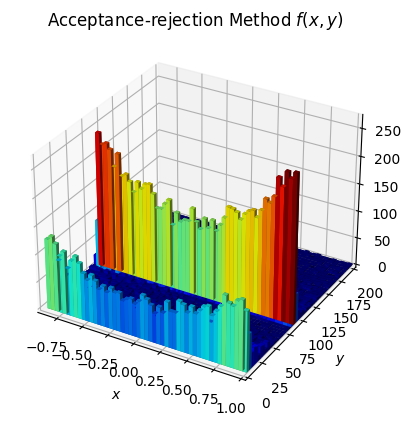

Acceptance-rejection method nPoints=29000, nFunctionEval=1083693, maxWeightEncounteredRej=6.781346833879538e-07


In [46]:
def brute_force(nPoints, seed=None):
    nFunctionEval = 0
    yy1_rej_method = []
    yy2_rej_method = []
    maxWeightEncounteredRej = -1.0e20
    F_VAL_MAX = maxWeightEncounteredRej
    generator = np.random.RandomState(seed=seed)
    while len(yy1_rej_method) < nPoints:
        # sampling (y1, y2) from uniform distribution
        rr = generator.uniform(size=3)
        yy1, yy2 = XMIN + rr[0] * (XMAX - XMIN), YMIN + rr[1] * (YMAX - YMIN)
        nFunctionEval += 1

        # evaluate function at (y1, y2)
        f_val = differential_cross_section(yy1**2, yy2)

        if f_val > maxWeightEncounteredRej:
            maxWeightEncounteredRej = f_val
            F_VAL_MAX = maxWeightEncounteredRej
        if f_val > F_VAL_MAX:

            print(
                f" f_val={f_val} exceeds F_VAL_MAX={F_VAL_MAX}, program will now exit"
            )
            exit(99)

        if f_val / F_VAL_MAX > rr[2]:
            yy1_rej_method.append(yy1)
            yy2_rej_method.append(yy2)
    return {
        "yy1": yy1_rej_method,
        "yy2": yy2_rej_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncounteredRej,
        "F_VAL_MAX": F_VAL_MAX
    }

def plot_results(
    nPoints,
    vegasRatioFactor,
    nBins=50,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    import time
    num_samples = []
    times = []
    for i in range(1,30):
      start = time.time()

      bf = brute_force(nPoints*i, seed)

      times.append(time.time() - start)
      num_samples.append(bf["nFunEval"])

    # brute force
    titleRej = r"Acceptance-rejection Method $f(x,y)$"
    lego_plot(bf["yy1"], bf["yy2"], nBins, "$x$", "$y$", titleRej)
    plt.show()

    print(
        f"Acceptance-rejection method nPoints={nPoints*i}, nFunctionEval={bf['nFunEval']}, maxWeightEncounteredRej={bf['maxWeightEncountered']}"
    )

    global F_VAL_MAX
    F_VAL_MAX = bf["F_VAL_MAX"]
    return num_samples, times

num_samples_stat_bf, times_bf = plot_results(1_000, 0.1, seed = 1)

In [39]:
def setup_intervals(NN=100, KK=1000, nIterations=4000, alpha_damp=1.5, seed=None):
    """
    Input:
        NN: Number of intervals in [XMIN, XMAX] or [YMIN, YMAX]
        KK: function evaluations per iteration
        nIterations: number of iterations
        alpha_damp: damping parameter in the Vegas algorithm
    Return:
        Intervals specified by xLow, yLow: each is a 1D numpy array of size NN+1, with
        xLow[0] = 0, xLow[NN] = ym; yLow[0] = 0, yLow[NN] = ym
    """

    # intitial intervals: uniform intervals between XMIN/YMIN and XMAX/YMAX
    xLow = XMIN + (XMAX - XMIN) / NN * np.arange(NN + 1)
    delx = np.ones(NN) * (XMAX - XMIN) / NN
    px = np.ones(NN) / (XMAX - XMIN)  # probability density in each interval
    yLow = YMIN + (YMAX - YMIN) / NN * np.arange(NN + 1)
    dely = np.ones(NN) * (YMAX - YMIN) / NN
    py = np.ones(NN) / (YMAX - YMIN)

    generator = np.random.RandomState(seed=seed)
    for _ in range(nIterations):
        ixLow = generator.randint(0, NN, size=KK)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform(size=KK)
        iyLow = generator.randint(0, NN, size=KK)
        yy = yLow[iyLow] + dely[iyLow] * generator.uniform(size=KK)
        ff = differential_cross_section(xx**2, yy)
        f2barx = np.array(
            [sum((ff[ixLow == i] / py[iyLow[ixLow == i]]) ** 2) for i in range(NN)]
        )
        fbarx = np.sqrt(f2barx)
        f2bary = np.array(
            [sum((ff[iyLow == i] / px[ixLow[iyLow == i]]) ** 2) for i in range(NN)]
        )
        fbary = np.sqrt(f2bary)
        fbardelxSum = np.sum(fbarx * delx)
        fbardelySum = np.sum(fbary * dely)
        logArgx = fbarx * delx / fbardelxSum
        logArgy = fbary * dely / fbardelySum
        mmx = KK * pow((logArgx - 1) / np.log(logArgx), alpha_damp)
        mmx = mmx.astype(int)
        mmx = np.where(mmx > 1, mmx, 1)
        mmy = KK * pow((logArgy - 1) / np.log(logArgy), alpha_damp)
        mmy = mmy.astype(int)
        mmy = np.where(mmy > 1, mmy, 1)
        xLowNew = [xLow[i] + np.arange(mmx[i]) * delx[i] / mmx[i] for i in range(NN)]
        xLowNew = np.concatenate(xLowNew, axis=0)
        yLowNew = [yLow[i] + np.arange(mmy[i]) * dely[i] / mmy[i] for i in range(NN)]
        yLowNew = np.concatenate(yLowNew, axis=0)
        nCombx = int(len(xLowNew) / NN)
        nComby = int(len(yLowNew) / NN)
        i = np.arange(NN)
        xLow[:-1] = xLowNew[i * nCombx]
        yLow[:-1] = yLowNew[i * nComby]
        delx = np.diff(xLow)
        dely = np.diff(yLow)
        px = 1.0 / delx / NN
        py = 1.0 / dely / NN

    return xLow, yLow, delx, dely

def vegas(
    nPoints,
    vegasRatioFactor,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    F_VAL_MAX = 6.659139746175817e-07
    xLow, yLow, delx, dely = setup_intervals(NN, KK, nIterations, alpha_damp, seed)
    vegasRatioMax = vegasRatioFactor * F_VAL_MAX * NN * NN * delx[NN - 2] * dely[NN - 2]
    nFunctionEval = 0
    yy1_vegas_method = []
    yy2_vegas_method = []
    yy1_vrho_method = []
    yy2_vrho_method = []
    maxWeightEncountered = -1.0e20

    generator = np.random.RandomState(seed=seed)
    while len(yy1_vegas_method) < nPoints:
        ixLow = generator.randint(0, NN)
        xx = xLow[ixLow] + delx[ixLow] * generator.uniform()
        iyLow = generator.randint(0, NN)
        yy = yLow[iyLow]
        dy = dely[iyLow] * generator.uniform()
        yy = yy + dy

        yy1_vrho_method.append(xx)
        yy2_vrho_method.append(yy)
        nFunctionEval += 1
        f_val = differential_cross_section(xx**2, yy)
        ratio = f_val * NN * NN * delx[ixLow] * dely[iyLow]

        if ratio > maxWeightEncountered:
            maxWeightEncountered = ratio
            vegasRatioMax = maxWeightEncountered
        if ratio > vegasRatioMax:
            print(
                f"ratio={ratio} exceeds vegasRatioMax={vegasRatioMax}, yy={yy} program will now exit "
            )
            exit(99)
        if ratio / vegasRatioMax > generator.uniform():
            yy1_vegas_method.append(xx)
            yy2_vegas_method.append(yy)

    return {
        "yy1vrho": yy1_vrho_method,
        "yy2vrho": yy2_vrho_method,
        "yy1vegas": yy1_vegas_method,
        "yy2vegas": yy2_vegas_method,
        "nFunEval": nFunctionEval,
        "maxWeightEncountered": maxWeightEncountered,
        "vegasRatioMax": vegasRatioMax,
    }

<ipython-input-31-553faa4219bb>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')
<ipython-input-31-553faa4219bb>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xticklabels)
<ipython-input-31-553faa4219bb>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(yticklabels)


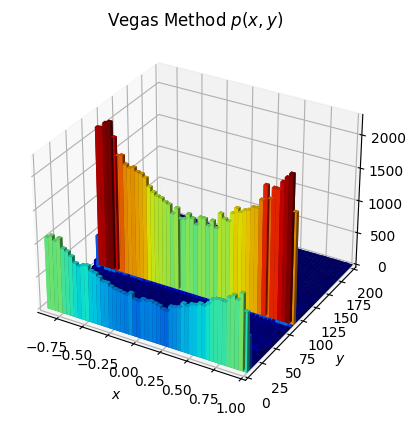

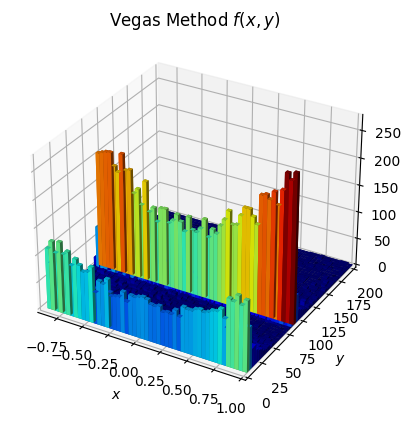

Vegas method nPoints=1000, nFunctionEval=263731, maxWeightEncountered=6.300728344680885e-05, vegasRatioMax=6.300728344680885e-05, vegasRatioFactor=0.1


In [44]:
def plot_results(
    nPoints,
    vegasRatioFactor,
    nBins=50,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    import time
    num_samples = []
    times = []
    for i in range(1,30):
      start = time.time()

      vg = vegas(nPoints*i, vegasRatioFactor, NN, KK, nIterations, alpha_damp, seed)

      times.append(time.time() - start)
      num_samples.append(vg['nFunEval'])

    # Vegas method
    titleVrho = r"Vegas Method $p(x,y)$"
    lego_plot(vg["yy1vrho"], vg["yy2vrho"], nBins, "$x$", "$y$", titleVrho)
    plt.show()

    titleVegas = r"Vegas Method $f(x,y)$"
    lego_plot(vg["yy1vegas"], vg["yy2vegas"], nBins, "$x$", "$y$", titleVegas)
    plt.show()

    print(
        f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
    )

    return num_samples, times
'''
for j in range(10):
  print("#"*20)
  print("n bins: ", 50+25*j)
  num_samples_stat_vg, times_vg = plot_results(10_000, 0.1, alpha_damp = 0.9, nIterations=4000, NN = 50+25*j)
  print("#"*20)
'''

num_samples_stat_vg, times_vg = plot_results(1_000, 0.1, nIterations=1000)

In [ ]:
# hyperparamter sweeps
# damping factor
for j in range(10):
    print("#"*20)
    print("n bins: ", 0.2 + 1.8/10 * j)
    num_samples_stat_vg, times_vg = plot_results(10_000, 0.1, alpha_damp = 0.2 + 1.8/10 * j)
    print("#"*20)

# nIterations
for j in range(1,5):
    print("#"*20)
    print("n bins: ", 1000*j)
    num_samples_stat_vg, times_vg = plot_results(10_000, 0.1, alpha_damp = 0.9, nIterations=1000*j)
    print("#"*20)

# number of bins
for j in range(10):
    print("#"*20)
    print("n bins: ", 50+25*j)
    num_samples_stat_vg, times_vg = plot_results(10_000, 0.1, alpha_damp = 0.9, nIterations=4000, NN = 50+25*j)
    print("#"*20)


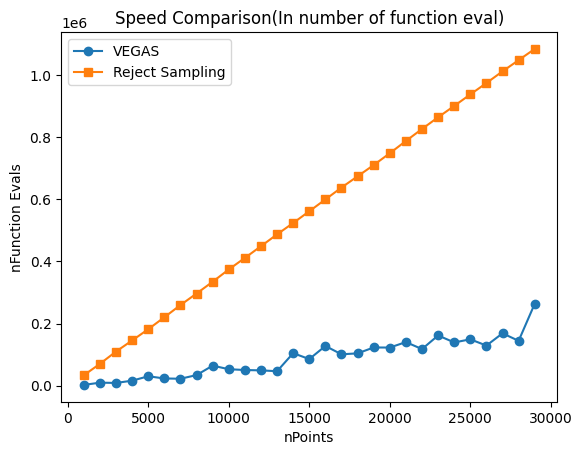

In [47]:
import matplotlib.pyplot as plt

plt.plot(np.array(list(range(1,30)))*1000, num_samples_stat_vg, label='VEGAS', marker='o')

# Plotting the second line
plt.plot(np.array(list(range(1,30)))*1000, num_samples_stat_bf, label='Reject Sampling', marker='s')

# Adding labels and a legend
plt.xlabel('nPoints')
plt.ylabel('nFunction Evals')
plt.title('Speed Comparison(In number of function eval)')
plt.legend()

# Display the plot
plt.show()

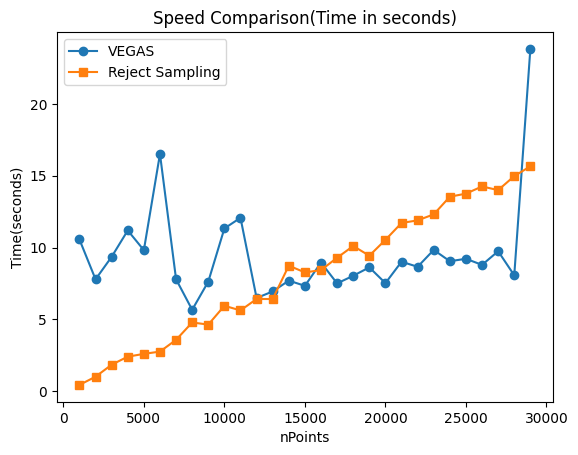

In [48]:
import matplotlib.pyplot as plt

plt.plot(np.array(list(range(1,30)))*1000, times_vg, label='VEGAS', marker='o')

# Plotting the second line
plt.plot(np.array(list(range(1,30)))*1000, times_bf, label='Reject Sampling', marker='s')

# Adding labels and a legend
plt.xlabel('nPoints')
plt.ylabel('Time(seconds)')
plt.title('Speed Comparison(Time in seconds)')
plt.legend()

# Display the plot
plt.show()

<ipython-input-31-553faa4219bb>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')
<ipython-input-31-553faa4219bb>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xticklabels)
<ipython-input-31-553faa4219bb>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(yticklabels)


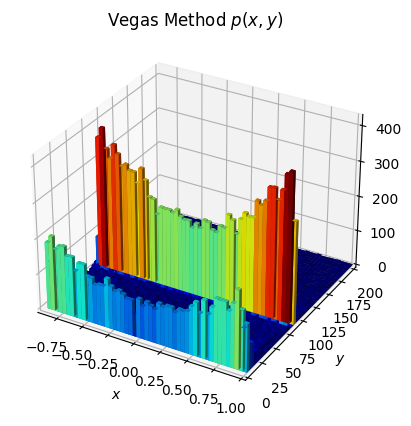

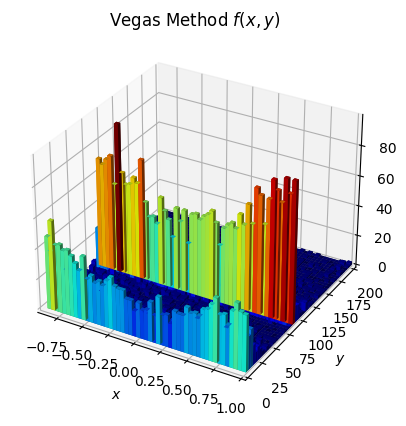

Vegas method nPoints=10000, nFunctionEval=46291, maxWeightEncountered=4.269850330215919e-05, vegasRatioMax=4.269850330215919e-05, vegasRatioFactor=0.1


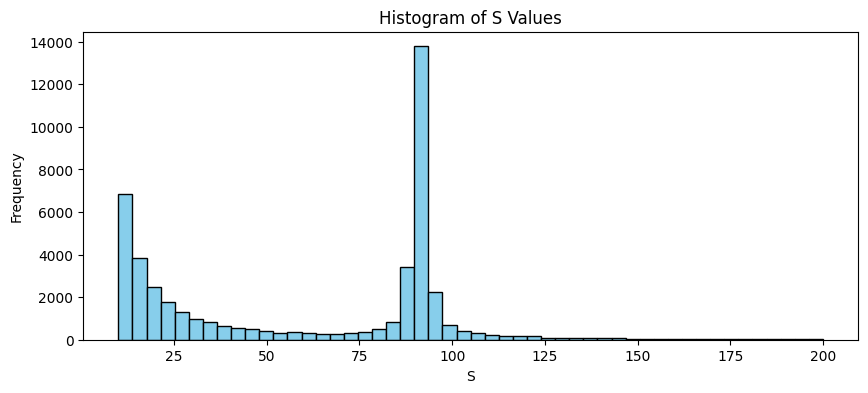

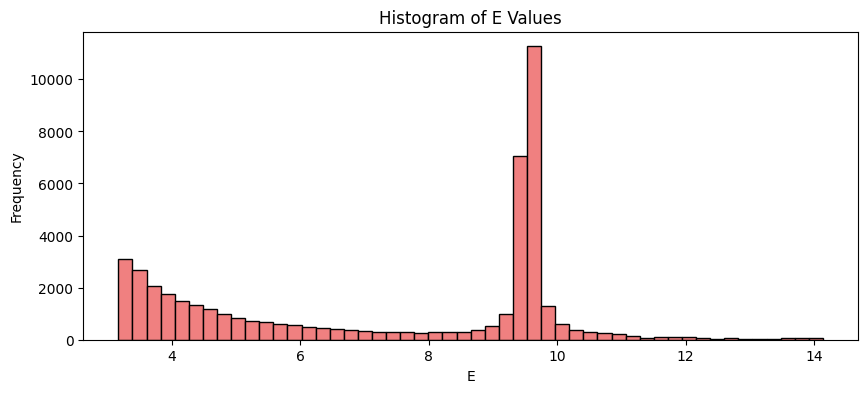

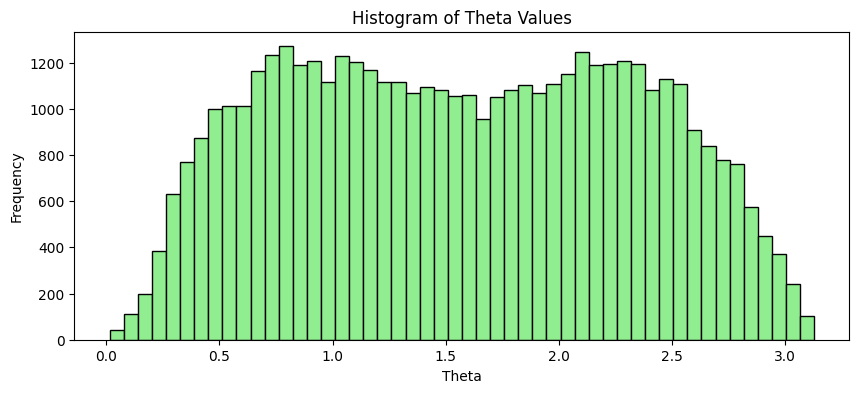

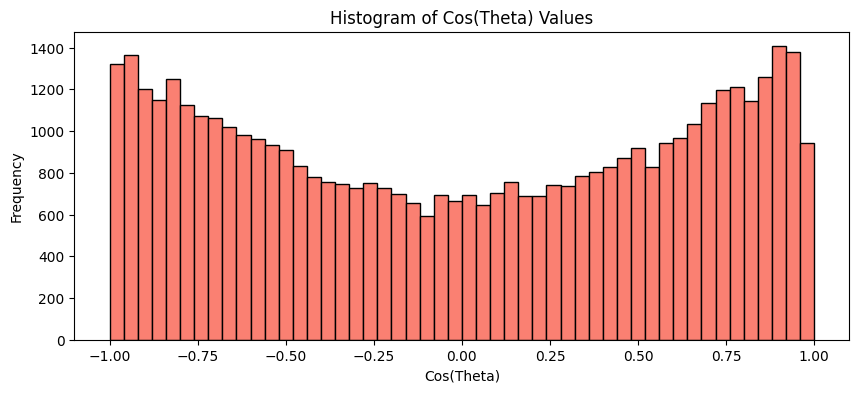

In [50]:
def plot_results2(
    nPoints,
    vegasRatioFactor,
    nBins=50,
    NN=100,
    KK=2000,
    nIterations=4000,
    alpha_damp=1.5,
    seed=None,
):
    import time
    num_samples = []
    times = []
    start = time.time()

    vg = vegas(nPoints, vegasRatioFactor, NN, KK, nIterations, alpha_damp, seed)

    times.append(time.time() - start)
    num_samples.append(vg['nFunEval'])

    # Vegas method
    titleVrho = r"Vegas Method $p(x,y)$"
    lego_plot(vg["yy1vrho"], vg["yy2vrho"], nBins, "$x$", "$y$", titleVrho)
    plt.show()

    titleVegas = r"Vegas Method $f(x,y)$"
    lego_plot(vg["yy1vegas"], vg["yy2vegas"], nBins, "$x$", "$y$", titleVegas)
    plt.show()

    print(
        f"Vegas method nPoints={nPoints}, nFunctionEval={vg['nFunEval']}, maxWeightEncountered={vg['maxWeightEncountered']}, vegasRatioMax={vg['vegasRatioMax']}, vegasRatioFactor={vegasRatioFactor}"
    )

    return vg

def s_to_E(s):
    return np.sqrt(s)

def plot_histograms(s_values, angle_values, nBins):
    # Plot histogram for S
    plt.figure(figsize=(10, 4))
    plt.hist(s_values, bins=nBins, color='skyblue', edgecolor='black')
    plt.title('Histogram of S Values')
    plt.xlabel('S')
    plt.ylabel('Frequency')
    plt.show()

      # Plot histogram for E
    plt.figure(figsize=(10, 4))
    plt.hist(s_to_E(s_values), bins=nBins, color='lightcoral', edgecolor='black')
    plt.title('Histogram of E Values')
    plt.xlabel('E')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for theta
    plt.figure(figsize=(10, 4))
    plt.hist(np.arccos(angle_values), bins=nBins, color='lightgreen', edgecolor='black')
    plt.title('Histogram of Theta Values')
    plt.xlabel('Theta')
    plt.ylabel('Frequency')
    plt.show()

    # Plot histogram for cos(theta)
    plt.figure(figsize=(10, 4))
    plt.hist((angle_values), bins=nBins, color='salmon', edgecolor='black')
    plt.title('Histogram of Cos(Theta) Values')
    plt.xlabel('Cos(Theta)')
    plt.ylabel('Frequency')
    plt.show()

veg = plot_results2(10_000, 0.1)
plot_histograms(veg["yy1vrho"], veg["yy2vrho"], 50)